# **Import Dataset**

In [ ]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
import os
os.environ["TF_GPU_ALLOCATOR"]='cuda_malloc_async'
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]='1.00'

In [ ]:
import kagglehub
path=kagglehub.dataset_download("abdullahkhan70/lumbar-spinal-mri-dataset")
print("Path to dataset files:",path)

100%|██████████| 52.2M/52.2M [00:00<00:00, 104MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/abdullahkhan70/lumbar-spinal-mri-dataset/versions/1


In [ ]:
from pathlib import Path
import os

# kagglehub에서 받은 path 변수를 기반으로
base = Path(path)  # path는 위에서 kagglehub.dataset_download가 반환한 경로
print("BASE:", base)

# 폴더 구조 확인
for dirpath, dirnames, filenames in os.walk(base):
    print(dirpath)
    # 필요하면 break 제거하고 전체 구조 확인
    break

# training / testing 폴더 탐색
candidates_train = [p for p in base.rglob('*training*') if p.is_dir()]
candidates_test  = [p for p in base.rglob('*testing*') if p.is_dir()]

print("train candidates:", candidates_train)
print("test candidates :", candidates_test)

# 첫 번째 후보를 경로로 지정
train_path = str(candidates_train[0])
test_path  = str(candidates_test[0])

print("train_path:", train_path)
print("test_path :", test_path)


BASE: /root/.cache/kagglehub/datasets/abdullahkhan70/lumbar-spinal-mri-dataset/versions/1
/root/.cache/kagglehub/datasets/abdullahkhan70/lumbar-spinal-mri-dataset/versions/1
train candidates: [PosixPath('/root/.cache/kagglehub/datasets/abdullahkhan70/lumbar-spinal-mri-dataset/versions/1/lumbar_spinal_dataset/training')]
test candidates : [PosixPath('/root/.cache/kagglehub/datasets/abdullahkhan70/lumbar-spinal-mri-dataset/versions/1/lumbar_spinal_dataset/testing')]
train_path: /root/.cache/kagglehub/datasets/abdullahkhan70/lumbar-spinal-mri-dataset/versions/1/lumbar_spinal_dataset/training
test_path : /root/.cache/kagglehub/datasets/abdullahkhan70/lumbar-spinal-mri-dataset/versions/1/lumbar_spinal_dataset/testing


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_path='/root/.cache/kagglehub/datasets/abdullahkhan70/lumbar-spinal-mri-dataset/versions/1/lumbar_spinal_dataset/training'
test_path='/root/.cache/kagglehub/datasets/abdullahkhan70/lumbar-spinal-mri-dataset/versions/1/lumbar_spinal_dataset/testing'

# **Data Augmentation and Preprocessing**

In [ ]:
#원본 이미지를 학습 전에 무작위로 변형(회전, 이동, 확대, 반전 등)하여 데이터 다양성을 늘리고 모델이 다양한 상황에 잘 대응하도록 하기 위해 데이터 증강
#또한, 픽셀 값을 0~1로 정규화하여 모델 학습 안정성을 높이고, 검증용 데이터를 자동으로 분리

train_datagen = ImageDataGenerator(
    rescale=1./255,          # 픽셀 값을 0~255 → 0~1 범위로 정규화
    rotation_range=30,       # 최대 ±30도 범위로 랜덤 회전
    width_shift_range=0.2,   # 가로 방향으로 최대 20%까지 랜덤 이동
    height_shift_range=0.2,  # 세로 방향으로 최대 20%까지 랜덤 이동
    shear_range=0.2,         # 이미지 기울이기 변환(전단 변환) 최대 0.2 라디안
    zoom_range=0.2,          # 80%~120% 범위에서 랜덤 확대/축소
    horizontal_flip=True,    # 이미지를 좌우 반전
    validation_split=0.2     # 전체 데이터 중 20%를 검증용 데이터로 분리
)

In [ ]:
#원본 형태를 유지해, 실제 데이터에서의 성능을 정확하게 평가하기 위해
#검증데이터는 데이터증강을 하지 않음
#만약 여기서 증강을 넣으면, 평가 시 원본과 다른 변형 이미지가 들어가 성능 지표가 왜곡될 수 있음.

val_test_datagen = ImageDataGenerator(
    rescale=1.0/255,   # 픽셀 값을 0~255 → 0~1 범위로 스케일링
    validation_split=0.2  # 전체 데이터 중 20%를 검증 데이터로 분리
)

In [ ]:
#train_path 안의 이미지들 중에서 validation_split=0.2로 설정한 80%를 가져와서,
#데이터 증강을 적용하며 학습에 사용할 수 있는 배치 형태로 불러옴

train_data = train_datagen.flow_from_directory(
    train_path,              # 이미지가 저장된 폴더 경로
    target_size=(224,224),   # 모든 이미지를 224×224 크기로 변환
    batch_size=32,           # 한 번에 불러올 이미지 개수
    class_mode='categorical',# 다중 클래스 분류 → 라벨을 one-hot 인코딩
    shuffle=True,            # 학습 데이터는 매 epoch마다 순서를 섞음
    subset='training'        # validation_split에서 지정한 '학습 데이터' 부분만 사용
)


Found 3848 images belonging to 3 classes.


In [ ]:
#val_test_datagen 을 이용해서 검증(validation) 데이터셋을 생성
#train_path에 있는 데이터 중에서 validation_split=0.2로 설정한 20% 데이터를 뽑아서, 모델 평가용으로 쓸 수 있게 배치 형태로 불러옴

val_data = val_test_datagen.flow_from_directory(
    train_path,              # 이미지 폴더 경로
    target_size=(224,224),   # 모든 이미지를 224×224 크기로 변환
    batch_size=32,           # 한 번에 가져올 이미지 개수
    class_mode='categorical',# 다중 클래스 분류(one-hot 인코딩)
    shuffle=False,           # 데이터 순서 섞지 않음
    subset='validation'      # 전체 데이터 중 validation_split에 해당하는 검증 데이터만 로드
)

Found 960 images belonging to 3 classes.


In [ ]:
#test data 생성

test_data = val_test_datagen.flow_from_directory(
    test_path,              # 테스트 이미지가 저장된 폴더 경로
    target_size=(224,224),  # 모든 이미지를 224×224 크기로 변환
    batch_size=32,          # 한 번에 불러올 이미지 개수
    class_mode='categorical',# 다중 클래스 분류 → 원-핫 인코딩 형태로 라벨 생성
    shuffle=False           # 순서 유지 (평가 시 필수)
)


Found 1158 images belonging to 3 classes.


# **EDA**

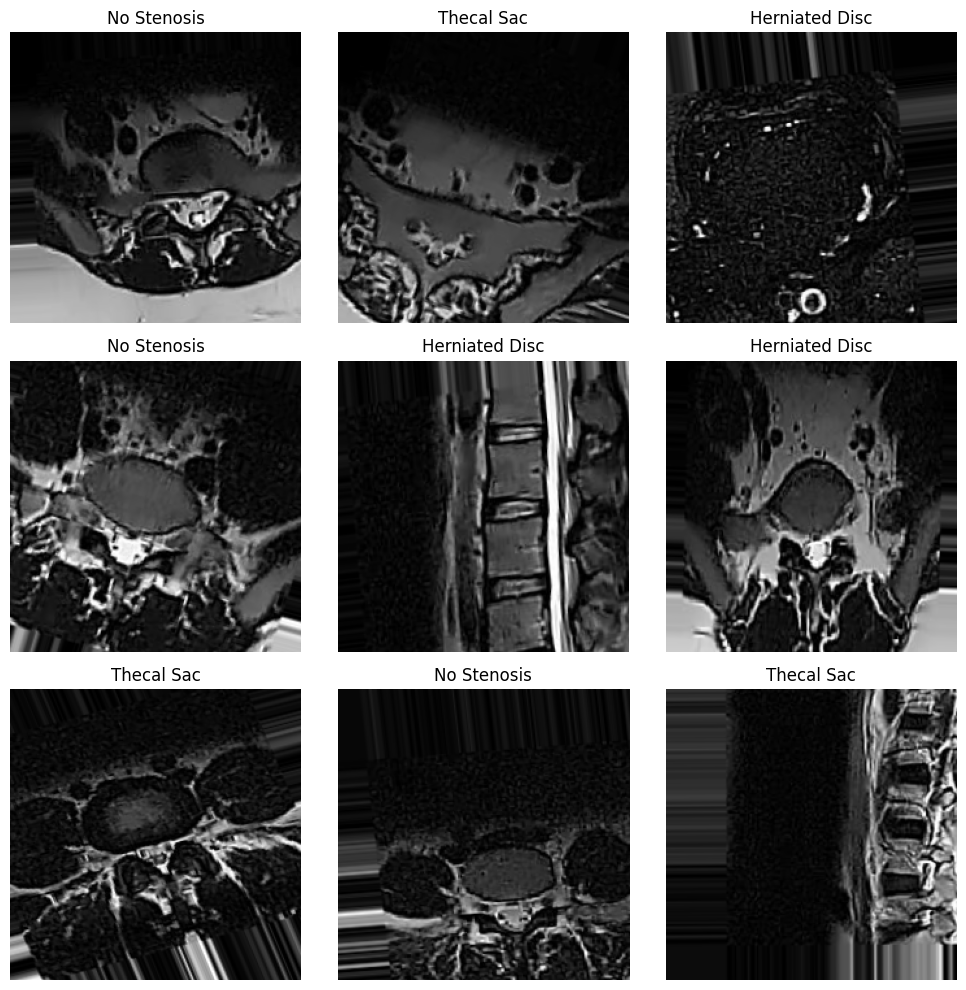

In [ ]:
#train_data에서 배치 단위로 불러온 이미지 샘플을 시각화
#즉, 데이터 증강이 잘 적용됐는지, 이미지와 라벨이 정상적으로 불려오는지 확인

import matplotlib.pyplot as plt
import numpy as np

# 클래스 인덱스 → 클래스 이름 매핑 (예: {0:'cat', 1:'dog'})
class_names = list(train_data.class_indices.keys())

# 한 배치 가져오기
sample_images, sample_labels = next(train_data)

plt.figure(figsize=(10,10))

for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(sample_images[i])

    # 원-핫 라벨 → 인덱스 변환
    label_index = np.argmax(sample_labels[i])
    label_name = class_names[label_index]

    # 제목에 클래스 이름 표시
    plt.title(label_name)
    plt.axis('off')

plt.tight_layout()
plt.show()



In [ ]:
#이미지 크기 & 채널 수 확인

print("Image shape:", sample_images.shape)

Image shape: (32, 224, 224, 3)


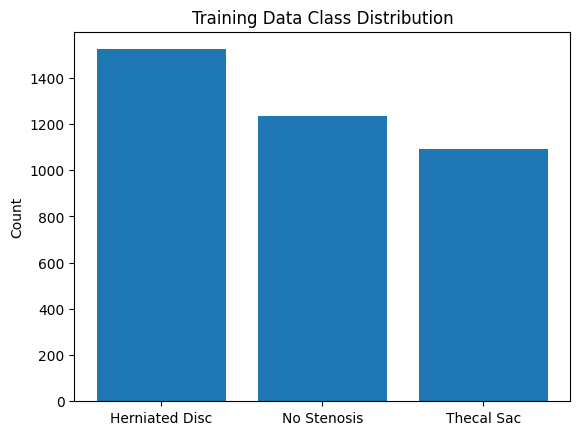

In [ ]:
#클래스 균형 확인

import matplotlib.pyplot as plt
import pandas as pd

# train_data.classes → 각 샘플의 클래스 인덱스
class_counts = pd.Series(train_data.classes).value_counts().sort_index()
class_names = list(train_data.class_indices.keys())

plt.bar(class_names, class_counts)
plt.title("Training Data Class Distribution")
plt.ylabel("Count")
plt.show()


# **Baseline by using Shallow CNN**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# 클래스 개수 / 이름
num_classes = train_data.num_classes
class_names = list(train_data.class_indices.keys())
print(class_names)

['Herniated Disc', 'No Stenosis', 'Thecal Sac']


In [ ]:
# 2층 CNN 베이스라인
model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    layers.Conv2D(16, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu', padding='same'),
    layers.GlobalAveragePooling2D(),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,187 (20.26 KB)

 Trainable params: 5,187 (20.26 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 콜백 설정
cbs = [
    callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor='val_loss'),
    callbacks.ModelCheckpoint('baseline_2layer_cnn.keras', save_best_only=True, monitor='val_loss')
]

# 학습 실행
history = model.fit(train_data, validation_data=val_data, epochs=10, callbacks=cbs)


Epoch 1/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3879 - loss: 1.0902

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


121/121 ━━━━━━━━━━━━━━━━━━━━ 191s 2s/step - accuracy: 0.3879 - loss: 1.0902 - val_accuracy: 0.3958 - val_loss: 1.0895
Epoch 2/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 190s 2s/step - accuracy: 0.3972 - loss: 1.0902 - val_accuracy: 0.3958 - val_loss: 1.0889
Epoch 3/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 188s 2s/step - accuracy: 0.4058 - loss: 1.0867 - val_accuracy: 0.3958 - val_loss: 1.0886
Epoch 4/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 191s 2s/step - accuracy: 0.3986 - loss: 1.0892 - val_accuracy: 0.3958 - val_loss: 1.0901
Epoch 5/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - accuracy: 0.4068 - loss: 1.0857 - val_accuracy: 0.3562 - val_loss: 1.0903
Epoch 6/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 186s 2s/step - accuracy: 0.4094 - loss: 1.0852 - val_accuracy: 0.3656 - val_loss: 1.0901


In [ ]:
# 테스트셋 성능 평가
test_loss, test_acc = model.evaluate(test_data, verbose=0)
print(f"[Test] Loss: {test_loss:.4f} | Acc: {test_acc:.4f}")

# 예측 & 리포트
y_true = test_data.classes
y_prob = model.predict(test_data, verbose=0)
y_pred = np.argmax(y_prob, axis=1)

print("\nClassification Report")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

print("Confusion Matrix")
print(confusion_matrix(y_true, y_pred))


[Test] Loss: 1.1609 | Acc: 0.2219

Classification Report
                precision    recall  f1-score   support

Herniated Disc     0.2219    1.0000    0.3633       257
   No Stenosis     0.0000    0.0000    0.0000       289
    Thecal Sac     0.0000    0.0000    0.0000       612

      accuracy                         0.2219      1158
     macro avg     0.0740    0.3333    0.1211      1158
  weighted avg     0.0493    0.2219    0.0806      1158

Confusion Matrix
[[257   0   0]
 [289   0   0]
 [612   0   0]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# **Using EfficeintnetB0**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

num_classes = train_data.num_classes
class_names = list(train_data.class_indices.keys())

# ----- 모델 구성 -----
inputs = layers.Input(shape=(224,224,3))
x = layers.Rescaling(255.0)(inputs)         # 0~1 -> 0~255
x = layers.Lambda(preprocess_input)(x)      # 0~255 -> [-1,1] (EffNet 규격)

base = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224,224,3), pooling='avg')
base.trainable = False                      # 1단계: feature extractor로 고정

x = base(x, training=False)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model = models.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

# ----- 콜백 -----
cbs = [
    callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5),
    callbacks.ModelCheckpoint('effb0_baseline.keras', monitor='val_loss', save_best_only=True)
]

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 1280)           │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │         3,843 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,053,414 (15.46 MB)

 Trainable params: 3,843 (15.01 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    callbacks=cbs,
    # class_weight=class_weights_dict,
    verbose=1
)

Epoch 1/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 459s 4s/step - accuracy: 0.3748 - loss: 1.1433 - val_accuracy: 0.3583 - val_loss: 1.1074 - learning_rate: 3.0000e-04
Epoch 2/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 377s 3s/step - accuracy: 0.3650 - loss: 1.1262 - val_accuracy: 0.3656 - val_loss: 1.1019 - learning_rate: 3.0000e-04
Epoch 3/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 379s 3s/step - accuracy: 0.4099 - loss: 1.0782 - val_accuracy: 0.4344 - val_loss: 1.0823 - learning_rate: 3.0000e-04
Epoch 4/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 372s 3s/step - accuracy: 0.4276 - loss: 1.0695 - val_accuracy: 0.4198 - val_loss: 1.1008 - learning_rate: 3.0000e-04
Epoch 5/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 372s 3s/step - accuracy: 0.4365 - loss: 1.0541 - val_accuracy: 0.4187 - val_loss: 1.0785 - learning_rate: 3.0000e-04
Epoch 6/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 391s 3s/step - accuracy: 0.4568 - loss: 1.0452 - val_accuracy: 0.4292 - val_loss: 1.0701 - learning_rate: 3.0000e-04
Epoch 7/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 369s 3s/step - acc

In [ ]:
# ----- 테스트 평가 -----
test_loss, test_acc = model.evaluate(test_data, verbose=0)
print(f"[EffB0 Frozen] Test Loss: {test_loss:.4f} | Acc: {test_acc:.4f}")

# 리포트/혼동행렬
y_true = test_data.classes
y_prob = model.predict(test_data, verbose=0)
y_pred = np.argmax(y_prob, axis=1)

print("\nClassification Report")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))
print("Confusion Matrix")
print(confusion_matrix(y_true, y_pred))

[EffB0 Frozen] Test Loss: 1.1864 | Acc: 0.3316

Classification Report
                precision    recall  f1-score   support

Herniated Disc     0.2410    0.4942    0.3240       257
   No Stenosis     0.3459    0.4118    0.3760       289
    Thecal Sac     0.4808    0.2255    0.3070       612

      accuracy                         0.3316      1158
     macro avg     0.3559    0.3771    0.3357      1158
  weighted avg     0.3939    0.3316    0.3280      1158

Confusion Matrix
[[127  61  69]
 [ 90 119  80]
 [310 164 138]]


In [ ]:
# 상위 몇 개 블록만 학습 (예: 마지막 20% 레이어)
base.trainable = True
for i, layer in enumerate(base.layers):
    layer.trainable = (i > int(0.8*len(base.layers)))   # 상위 20%만 True

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # 더 작은 lr
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_ft = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    callbacks=cbs,
    # class_weight=class_weights_dict,
    verbose=1
)

test_loss, test_acc = model.evaluate(test_data, verbose=0)
print(f"[EffB0 Fine-tuned] Test Loss: {test_loss:.4f} | Acc: {test_acc:.4f}")


Epoch 1/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 485s 4s/step - accuracy: 0.4771 - loss: 1.0254 - val_accuracy: 0.4198 - val_loss: 1.0673 - learning_rate: 1.0000e-04
Epoch 2/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 446s 4s/step - accuracy: 0.5344 - loss: 0.9668 - val_accuracy: 0.4563 - val_loss: 1.0639 - learning_rate: 1.0000e-04
Epoch 3/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 440s 4s/step - accuracy: 0.5771 - loss: 0.9120 - val_accuracy: 0.4385 - val_loss: 1.1029 - learning_rate: 1.0000e-04
Epoch 4/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 441s 4s/step - accuracy: 0.5890 - loss: 0.8888 - val_accuracy: 0.4292 - val_loss: 1.1048 - learning_rate: 1.0000e-04
Epoch 5/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 441s 4s/step - accuracy: 0.6203 - loss: 0.8264 - val_accuracy: 0.4667 - val_loss: 1.1046 - learning_rate: 5.0000e-05
[EffB0 Fine-tuned] Test Loss: 1.1782 | Acc: 0.4024


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

# 1) 테스트셋 평가 (loss/acc)
test_loss, test_acc = model.evaluate(test_data, verbose=0)
print(f"[EffB0 Fine-tuned] Test Loss: {test_loss:.4f} | Acc: {test_acc:.4f}")

# 2) 리포트/혼동행렬
class_names = list(train_data.class_indices.keys())  # train 기준으로 통일
y_true = test_data.classes                           # 정답(정수)
y_prob = model.predict(test_data, verbose=0)         # 예측 확률
y_pred = np.argmax(y_prob, axis=1)                   # 예측 라벨

print("\nClassification Report")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix\n", cm)

# (선택) 정규화 혼동행렬도 보고 싶다면
cm_norm = cm / cm.sum(axis=1, keepdims=True)
print("\nConfusion Matrix (row-normalized)\n", np.round(cm_norm, 3))

# 3) 예측 결과 저장 (파일명/정답/예측/최대확률)
fnames = test_data.filenames
top_prob = y_prob.max(axis=1)
df_pred = pd.DataFrame({
    "filename": fnames,
    "y_true": [class_names[i] for i in y_true],
    "y_pred": [class_names[i] for i in y_pred],
    "prob": np.round(top_prob, 4),
})
df_pred.head(), df_pred.to_csv("test_predictions.csv", index=False)
print("\nSaved: test_predictions.csv")


[EffB0 Fine-tuned] Test Loss: 1.1782 | Acc: 0.4024

Classification Report
                precision    recall  f1-score   support

Herniated Disc     0.3250    0.4553    0.3793       257
   No Stenosis     0.3655    0.6298    0.4625       289
    Thecal Sac     0.5567    0.2729    0.3662       612

      accuracy                         0.4024      1158
     macro avg     0.4157    0.4526    0.4027      1158
  weighted avg     0.4575    0.4024    0.3931      1158


Confusion Matrix
 [[117  73  67]
 [ 41 182  66]
 [202 243 167]]

Confusion Matrix (row-normalized)
 [[0.455 0.284 0.261]
 [0.142 0.63  0.228]
 [0.33  0.397 0.273]]

Saved: test_predictions.csv


# **Using EfficientNetB3**

In [ ]:
# =========================
# EfficientNetB3 (IMG=300)
# Focal Loss + 2-stage FT
# 불균형 대응 + 리포트 출력
# =========================
import os, numpy as np, tensorflow as tf
from tensorflow.keras import layers, models, callbacks, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.optimizers import Adam, AdamW
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.utils.class_weight import compute_class_weight

SEED = 42
IMG  = 300
BATCH= 32
EPOCHS_STAGE1 = 8
EPOCHS_STAGE2 = 30

In [ ]:
# ======== 경로 확인 ========
assert 'train_path' in globals() and os.path.isdir(train_path), f"train_path가 없습니다: {globals().get('train_path', None)}"
HAS_TEST = ('test_path' in globals()) and os.path.isdir(test_path)

In [ ]:
# ======== Focal Loss (multiclass) ========
def focal_loss(gamma=2., alpha=0.25):
    def _focal(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1. - 1e-7)
        ce = -y_true * tf.math.log(y_pred)
        w  = alpha * tf.pow(1. - y_pred, gamma)
        return tf.reduce_mean(tf.reduce_sum(w * ce, axis=1))
    return _focal

In [ ]:
# ======== 데이터 제너레이터 ========
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=8,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.10,
    horizontal_flip=True,        # 해부학적으로 허용 시 유지
    brightness_range=(0.9, 1.1)
)
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_data = train_datagen.flow_from_directory(
    directory=train_path,
    target_size=(IMG, IMG),
    batch_size=BATCH,
    class_mode='categorical',
    shuffle=True,
    subset='training',
    seed=SEED
)
val_data = val_datagen.flow_from_directory(
    directory=train_path,
    target_size=(IMG, IMG),
    batch_size=BATCH,
    class_mode='categorical',
    shuffle=False,
    subset='validation',
    seed=SEED
)

num_classes = train_data.num_classes
class_names = [k for k,_ in sorted(train_data.class_indices.items(), key=lambda x:x[1])]
print("Classes:", train_data.class_indices)


Found 3848 images belonging to 3 classes.
Found 960 images belonging to 3 classes.
Classes: {'Herniated Disc': 0, 'No Stenosis': 1, 'Thecal Sac': 2}


In [ ]:
# ======== 모델 구성 ========
inputs = layers.Input(shape=(IMG, IMG, 3))
x = layers.Rescaling(255.0)(inputs)       # (0~1)->(0~255)
x = layers.Lambda(preprocess_input)(x)    # EfficientNet 전처리([-1,1])

base = EfficientNetB3(include_top=False, weights='imagenet', input_shape=(IMG, IMG, 3))
base.trainable = False  # Stage1: 동결

x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(num_classes, activation='softmax',
                       kernel_regularizer=regularizers.l2(1e-4))(x)
model = models.Model(inputs, outputs)

ckpt_path = "efnB3_focal_best.keras"
cbs = [
    callbacks.ModelCheckpoint(ckpt_path, monitor='val_loss', save_best_only=True, verbose=1),
    callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5, verbose=1)
]


43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# ======== Stage 1: top만 학습 ========
model.compile(optimizer=Adam(1e-3),
              loss=focal_loss(gamma=2, alpha=0.25),
              metrics=[tf.keras.metrics.AUC(name='auc', multi_label=True), 'accuracy'])
model.fit(train_data, validation_data=val_data,
          epochs=EPOCHS_STAGE1, callbacks=cbs, verbose=1)
print("[Stage1] done")

Epoch 1/8
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.3630 - auc: 0.5339 - loss: 0.1509
Epoch 1: val_loss improved from inf to 0.13044, saving model to efnB3_focal_best.keras
121/121 ━━━━━━━━━━━━━━━━━━━━ 834s 7s/step - accuracy: 0.3631 - auc: 0.5341 - loss: 0.1508 - val_accuracy: 0.3771 - val_auc: 0.5362 - val_loss: 0.1304 - learning_rate: 0.0010
Epoch 2/8
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.4167 - auc: 0.5963 - loss: 0.1298
Epoch 2: val_loss improved from 0.13044 to 0.12908, saving model to efnB3_focal_best.keras
121/121 ━━━━━━━━━━━━━━━━━━━━ 810s 7s/step - accuracy: 0.4168 - auc: 0.5964 - loss: 0.1298 - val_accuracy: 0.4344 - val_auc: 0.5678 - val_loss: 0.1291 - learning_rate: 0.0010
Epoch 3/8
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.4776 - auc: 0.6498 - loss: 0.1182
Epoch 3: val_loss improved from 0.12908 to 0.12392, saving model to efnB3_focal_best.keras
121/121 ━━━━━━━━━━━━━━━━━━━━ 842s 7s/step - accuracy: 0.4775 - auc: 0.6498 - loss: 0.1182

In [ ]:
# ======== Stage 2: 상위 블록만 언프리즈 후 미세조정 ========
base.trainable = True
# 마지막 ~40개 레이어만 학습 (필요시 숫자 조정)
for layer in base.layers[:-40]:
    layer.trainable = False

model.compile(optimizer=AdamW(learning_rate=3e-5, weight_decay=1e-4),
              loss=focal_loss(gamma=2, alpha=0.25),
              metrics=[tf.keras.metrics.AUC(name='auc', multi_label=True), 'accuracy'])
model.fit(train_data, validation_data=val_data,
          epochs=EPOCHS_STAGE2, callbacks=cbs, verbose=1)
print("[Stage2] done")

# ======== 검증 성능 ========
val_loss, val_auc, val_acc = model.evaluate(val_data, verbose=0)
print(f"[VAL] loss={val_loss:.4f}, auc={val_auc:.4f}, acc={val_acc:.4f}")

Epoch 1/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.3740 - auc: 0.5329 - loss: 0.1382
Epoch 1: val_loss improved from inf to 0.12248, saving model to efnB3_focal_best.keras
121/121 ━━━━━━━━━━━━━━━━━━━━ 1089s 9s/step - accuracy: 0.3740 - auc: 0.5330 - loss: 0.1382 - val_accuracy: 0.4198 - val_auc: 0.5881 - val_loss: 0.1225 - learning_rate: 3.0000e-05
Epoch 2/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.4387 - auc: 0.6106 - loss: 0.1220
Epoch 2: val_loss did not improve from 0.12248
121/121 ━━━━━━━━━━━━━━━━━━━━ 990s 8s/step - accuracy: 0.4388 - auc: 0.6107 - loss: 0.1220 - val_accuracy: 0.4187 - val_auc: 0.5979 - val_loss: 0.1232 - learning_rate: 3.0000e-05
Epoch 3/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.5079 - auc: 0.6747 - loss: 0.1109
Epoch 3: val_loss improved from 0.12248 to 0.12018, saving model to efnB3_focal_best.keras
121/121 ━━━━━━━━━━━━━━━━━━━━ 961s 8s/step - accuracy: 0.5077 - auc: 0.6747 - loss: 0.1109 - val_accuracy: 0.4375 - val_au

In [ ]:

# ======== (선택) 테스트 평가 ========
if HAS_TEST:
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_data = test_datagen.flow_from_directory(
        directory=test_path, target_size=(IMG, IMG),
        batch_size=BATCH, class_mode='categorical', shuffle=False
    )
    test_loss, test_auc, test_acc = model.evaluate(test_data, verbose=0)
    print(f"[TEST] loss={test_loss:.4f}, auc={test_auc:.4f}, acc={test_acc:.4f}")

    # 추가 지표 (Macro Precision/Recall/F1, 리포트/혼동행렬)
    y_true = test_data.classes
    y_prob = model.predict(test_data, verbose=0)
    y_pred = np.argmax(y_prob, axis=1)

    macro_p = precision_score(y_true, y_pred, average='macro', zero_division=0)
    macro_r = recall_score(y_true, y_pred, average='macro', zero_division=0)
    macro_f = f1_score(y_true, y_pred, average='macro', zero_division=0)
    print(f"[TEST] macro-precision={macro_p:.4f}, macro-recall={macro_r:.4f}, macro-f1={macro_f:.4f}")

    print("\n[TEST] classification report")
    print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

    print("[TEST] confusion matrix")
    print(confusion_matrix(y_true, y_pred))
else:
    print("(별도 test_path가 없어 TEST 평가는 건너뜀)")

Found 1158 images belonging to 3 classes.
[TEST] loss=0.1275, auc=0.6270, acc=0.4111
[TEST] macro-precision=0.4327, macro-recall=0.4743, macro-f1=0.4145

[TEST] classification report
                precision    recall  f1-score   support

Herniated Disc       0.35      0.55      0.43       257
   No Stenosis       0.37      0.62      0.46       289
    Thecal Sac       0.58      0.25      0.35       612

      accuracy                           0.41      1158
     macro avg       0.43      0.47      0.41      1158
  weighted avg       0.48      0.41      0.40      1158

[TEST] confusion matrix
[[141  62  54]
 [ 51 179  59]
 [210 246 156]]
